<a href="https://colab.research.google.com/github/dinaglamshowroom/projet-data_oc/blob/main/Projet5_NettoyageV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, glob
import pickle
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy import stats
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.metrics import pairwise_distances_argmin_min

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:

DATA_DIR = "/content/drive/MyDrive/Projet_5/Data"
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

print("Fichiers CSV trouvés :")
for f in csv_files:
    print(f)

Fichiers CSV trouvés :
/content/drive/MyDrive/Projet_5/Data/Disponibilité _viande_poulet_2022.csv
/content/drive/MyDrive/Projet_5/Data/Disponibilité_viande_poulet_2021.csv
/content/drive/MyDrive/Projet_5/Data/Population_2011_2021.csv
/content/drive/MyDrive/Projet_5/Data/PIB_2021.csv
/content/drive/MyDrive/Projet_5/Data/Disponibilité alimentiaire_totale_2021.csv
/content/drive/MyDrive/Projet_5/Data/disponibilité_elevage_2021.csv


In [9]:
dfs = {f.split("/")[-1]: pd.read_csv(f) for f in csv_files}

for name, df in dfs.items():
    print(f"{name}: {df.shape}")

Disponibilité _viande_poulet_2022.csv: (740, 15)
Disponibilité_viande_poulet_2021.csv: (740, 15)
Population_2011_2021.csv: (463, 15)
PIB_2021.csv: (381, 15)
Disponibilité alimentiaire_totale_2021.csv: (31144, 15)
disponibilité_elevage_2021.csv: (23660, 15)


In [19]:
df_dispo = dfs["Disponibilité_viande_poulet_2021.csv"]
df_PIB = dfs["PIB_2021.csv"]
df_pop = dfs["Population_2011_2021.csv"]
df_dispo_totale = dfs["Disponibilité alimentiaire_totale_2021.csv"]
df_dispo_elevage = dfs["disponibilité_elevage_2021.csv"]


In [20]:
# Extraire les années 2011 et 2021
pop = df_pop[df_pop["Année"].isin([2011, 2021])]

# Pivot table pour avoir colonnes 2011 / 2021 côte à côte
pop_pivot = pop.pivot_table(index="Zone", columns="Année", values="Valeur").reset_index()
pop_pivot["pop_evo_ratio"] = ((pop_pivot[2021] - pop_pivot[2011]) / pop_pivot[2011]) * 100


In [21]:
prot_anim = df_dispo_elevage[
    df_dispo_elevage["Élément"].str.contains("protéines", case=False)
]

prot_anim = prot_anim.groupby("Zone")["Valeur"].sum().reset_index()
prot_anim.columns = ["Pays", "proteines_anim_g_pers_jr"]


In [22]:
prot_tot = df_dispo_totale[
    df_dispo_totale["Élément"].str.contains("protéines", case=False)
]

prot_tot = prot_tot.groupby("Zone")["Valeur"].sum().reset_index()
prot_tot.columns = ["Pays", "proteines_total_g_pers_jr"]


In [23]:
prot_anim = df_dispo_elevage[
    df_dispo_elevage["Élément"].str.contains("protéines", case=False)
]

prot_anim = prot_anim.groupby("Zone")["Valeur"].sum().reset_index()
prot_anim.columns = ["Pays", "proteines_anim_g_pers_jr"]


In [24]:
prot = prot_tot.merge(prot_anim, on="Pays", how="inner")
prot["part_prot_anim"] = prot["proteines_anim_g_pers_jr"] / prot["proteines_total_g_pers_jr"]


In [25]:
kcal = df_dispo_totale[
    df_dispo_totale["Élément"].str.contains("Kcal", case=False)
]

kcal = kcal.groupby("Zone")["Valeur"].sum().reset_index()
kcal.columns = ["Pays", "kcal_total_pers_jr"]


In [26]:
# Fusion successive
df_X = prot.merge(kcal, on="Pays", how="inner")
df_X = df_X.merge(pop_pivot[["Zone", "pop_evo_ratio"]].rename(columns={"Zone": "Pays"}), on="Pays", how="inner")


In [67]:
pib = df_PIB[df_PIB["Produit"].str.contains("PIB", case=False)][["Zone", "Valeur"]]
pib.columns = ["Pays", "pib_par_habitant"]
df_X = df_X.merge(pib, on="Pays", how="left")


In [68]:
df_X.duplicated().sum()

np.int64(0)

In [31]:
df_X.isna().sum()

,0
Pays,0
proteines_total_g_pers_jr,0
proteines_anim_g_pers_jr,0
part_prot_anim,0
kcal_total_pers_jr,0
pop_evo_ratio,2
pib_par_habitant,8


In [33]:
df_X_clean = df_X.replace([np.inf, -np.inf], np.nan).dropna()

In [69]:
df_X_clean = df_X_clean.reset_index(drop=True)

In [35]:
df_X_clean.info()
df_X_clean.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Pays                       178 non-null    object 
 1   proteines_total_g_pers_jr  178 non-null    float64
 2   proteines_anim_g_pers_jr   178 non-null    float64
 3   part_prot_anim             178 non-null    float64
 4   kcal_total_pers_jr         178 non-null    float64
 5   pop_evo_ratio              178 non-null    float64
 6   pib_par_habitant           178 non-null    float64
dtypes: float64(6), object(1)
memory usage: 9.9+ KB


,proteines_total_g_pers_jr,proteines_anim_g_pers_jr,part_prot_anim,kcal_total_pers_jr,pop_evo_ratio,pib_par_habitant
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,89.276348,38.077022,0.393659,2938.732584,14.615604,23405.771348
std,23.898614,22.219035,0.164390,465.094502,14.231541,24153.165736
min,29.550000,2.100000,0.058867,1771.730000,-20.305546,836.700000
25%,71.202500,17.387500,0.260989,2617.352500,3.919512,5761.525000
50%,90.990000,37.215000,0.412521,2958.650000,12.974246,15289.350000
75%,108.640000,56.457500,0.533319,3297.652500,24.610461,33384.875000
max,150.710000,92.500000,0.694235,3898.190000,55.442282,136772.000000


In [102]:
df_main = df_X_clean[[
    "pop_evo_ratio",
    "proteines_total_g_pers_jr",
    "part_prot_anim",
    "kcal_total_pers_jr",
    'Pays'
]]


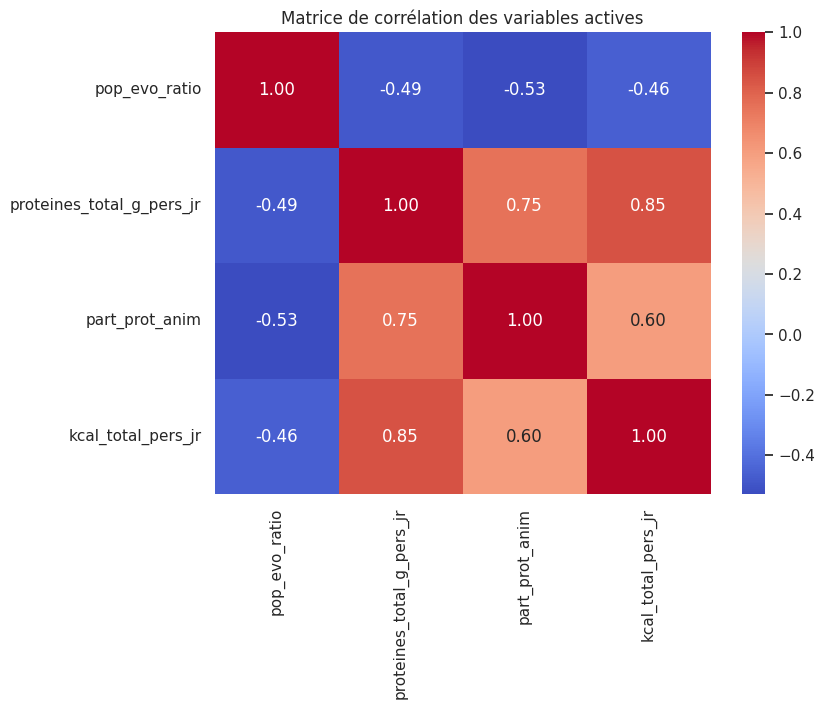

In [103]:
corr_df = df_main.copy()
if 'Pays' in corr_df.columns:
    corr_df = corr_df.drop(columns=["Pays"])

# Calcul de la matrice de corrélation
corr = corr_df.corr()

# Affichage de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation des variables actives")
plt.show()

* Forte corrélation : kcal_total_pers_jr - proteines_total_g_pers_jr (r = 0.85)

 * part_prot_anim bien liée aux protéines totales (r = 0.75)

* pop_evo_ratio modérément négatif avec les autres variables (~ -0.5)

Redondance potentielle entre calories et protéines totales?

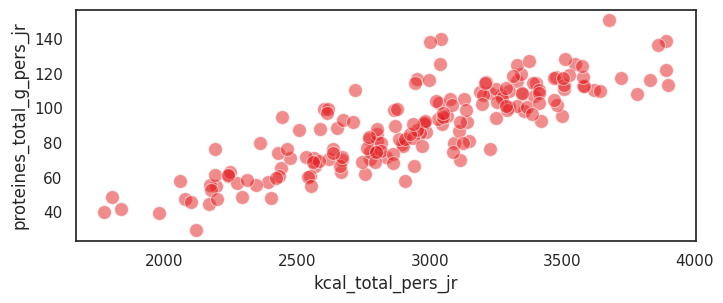

In [104]:
plt.figure(figsize=(8, 3))
sns.scatterplot(data=df_main, x='kcal_total_pers_jr', y='proteines_total_g_pers_jr', s=100, alpha=.5)
sns.set_theme(style="white", palette="Set2")
plt.show()


* Relation quasi-linéaire

* Logique nutritionnelle respectée

* Risque de redondance avec deux variables très proches

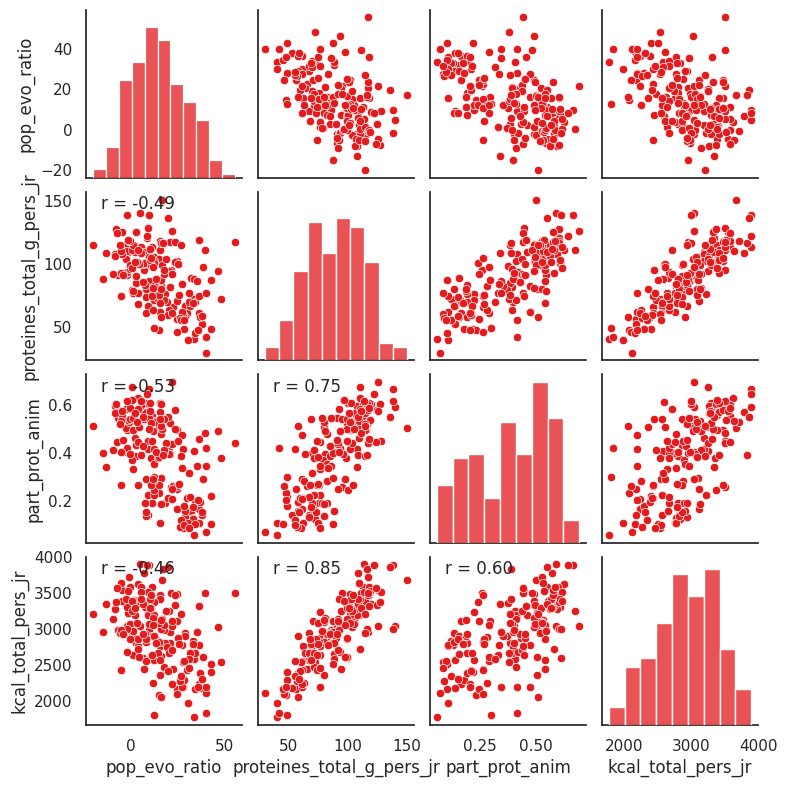

In [105]:
def corrfunc(x, y, **kwargs):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f"r = {r:.2f}", xy=(.1, .9), xycoords=ax.transAxes)

# 🧪 Sélection des colonnes numériques (et suppression éventuelle de "Pays")
corr_df = df_main.select_dtypes(include='number')

# 📊 Paramètres de style
sns.set_context('notebook', font_scale=0.9)
sns.set_theme(style="white", palette="Set1")

# 🔍 Création du pairplot avec corrélations annotées
g = sns.pairplot(corr_df, height=2)
g.map_lower(corrfunc)



plt.show()

* Sont visuellement différenciés, surtout selon pop_evo_ratio

* Corrélations linéaires visibles, peu de valeurs aberrantes

* part_prot_anim : bonne variabilité

# Classification Hierarchique Ascendante

In [107]:
df_dendo =df_main.set_index('Pays')

In [108]:
Z = linkage(df_dendo, method = 'ward')

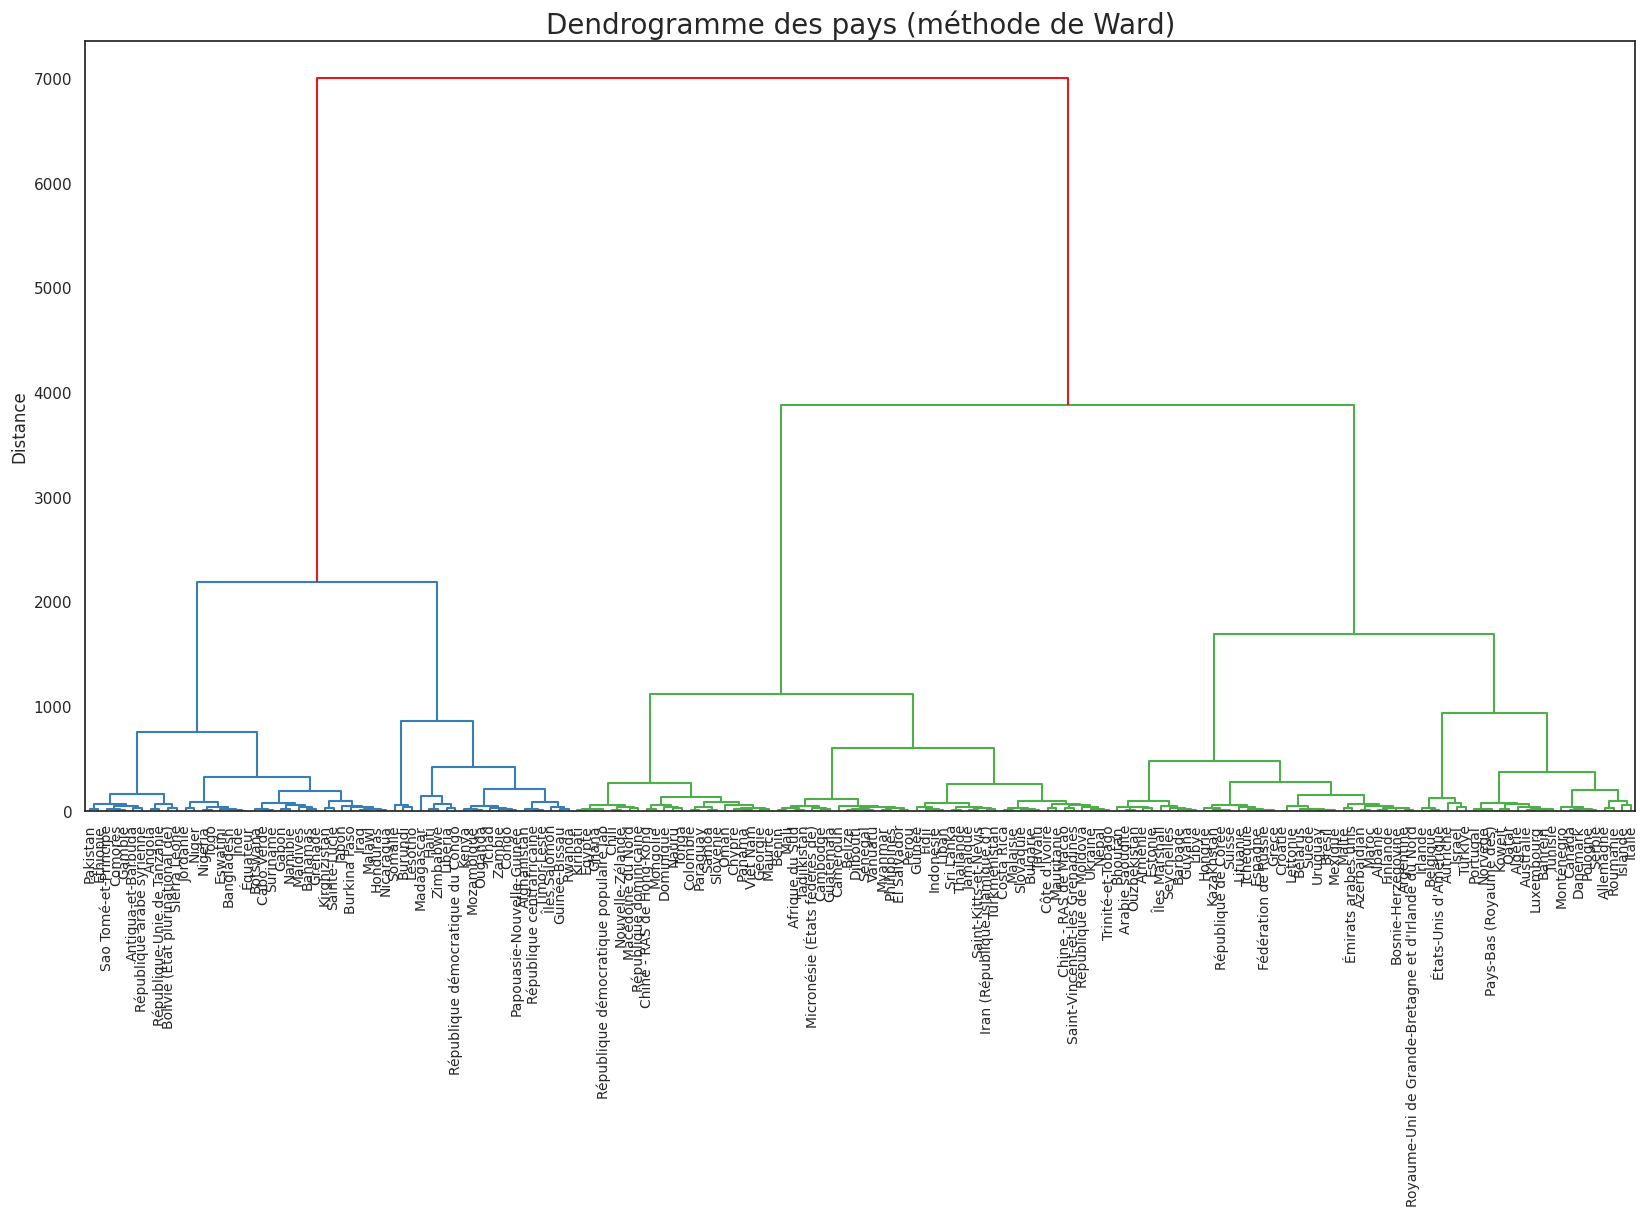

In [109]:
plt.figure(figsize=(20, 10))
sns.set_style('white')
plt.title('Dendrogramme des pays (méthode de Ward)', fontsize=20)
plt.ylabel('Distance', fontsize=12)

dendrogram(Z, labels=df_dendo.index, leaf_font_size=10, orientation='top')
plt.savefig("dendrogramme.png")
plt.show()


graphe de l'inertie expliquée en fonction du nombre de clustergraphe de l'inertie expliquée en fonction du nombre de cluster


In [122]:
X = df_dendo.values
X.shape

(178, 4)

In [123]:
scale = preprocessing.StandardScaler().fit(X)
X_scaled = scale.transform(X)

In [124]:


# On suppose que `X_scaled` est déjà créé (données standardisées)
Z = linkage(X_scaled, method='ward')

# Calcul de l'inertie pour k = 2 à 20
K = range(2, 25)
inertie = []

In [125]:
# Calcul de l'inertie pour k = 2 à 20
K = range(2, 25)
inertie = []

for k in K:
    labels = fcluster(Z, t=k, criterion='maxclust')

    # Calcul de l'inertie : somme des distances aux centroïdes
    groupes = [X[labels == i] for i in range(1, k+1)]
    inertie_k = 0
    for group in groupes:
        if len(group) > 0:
            center = group.mean(axis=0)
            dists = ((group - center) ** 2).sum()
            inertie_k += dists
    inertie.append(inertie_k)

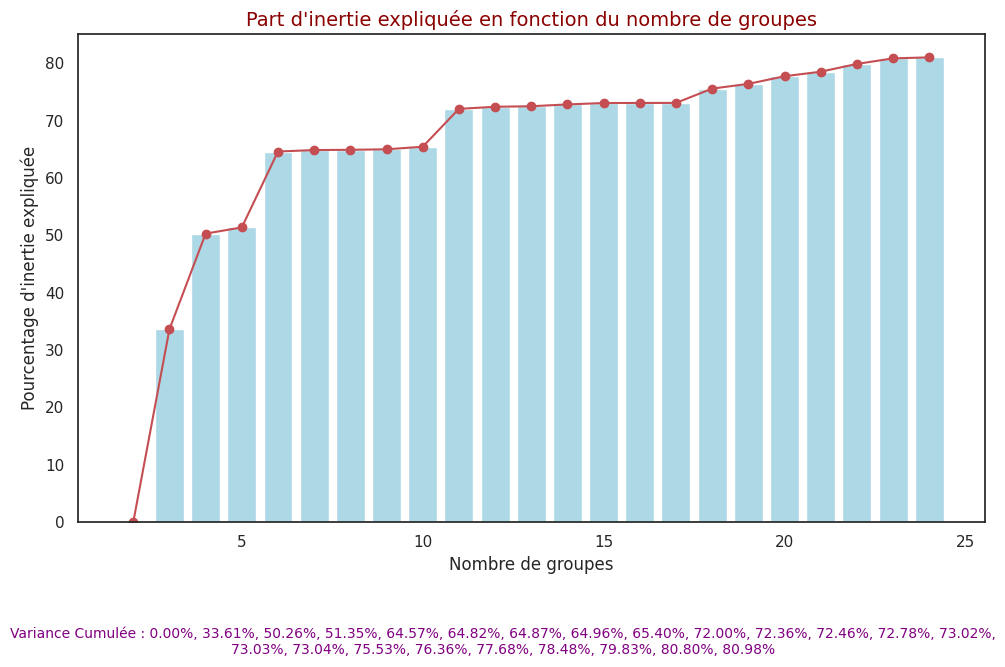

In [129]:
# Pourcentage d'inertie expliquée
inertie_totale = inertie[0]  # l'inertie avec k=2 sert de base
inertie_expliquee = [100 * (1 - i / inertie[0]) for i in inertie]

# Tracé
plt.figure(figsize=(10, 6))
plt.bar(K, inertie_expliquee, color='lightblue')
plt.plot(K, inertie_expliquee, 'o-r')
plt.title("Part d'inertie expliquée en fonction du nombre de groupes", fontsize=14, color='darkred')
plt.xlabel("Nombre de groupes")
plt.ylabel("Pourcentage d'inertie expliquée")

# Annotation de la variance cumulée
text = "Variance Cumulée : " + ", ".join([f"{v:.2f}%" for v in inertie_expliquee])
plt.figtext(0.5, -0.1, text, wrap=True, horizontalalignment='center', fontsize=10, color='purple')
plt.tight_layout()
plt.show()

passons au découpage

In [145]:
from scipy.cluster.hierarchy import fcluster

# Coupe du dendrogramme pour former 5 groupes
clusters = fcluster(Z, t=5, criterion='maxclust')

In [147]:
from scipy.cluster.hierarchy import fcluster

# Découpage en 5 clusters à partir de la matrice de linkage Z
clusters = fcluster(Z, t=5, criterion='maxclust')

# Ajout des labels de cluster au DataFrame initial
df_dendo.loc[:, "cluster"] = clusters



# Vérification rapide : combien de pays dans chaque groupe ?
df_dendo["cluster"].value_counts().sort_index()


,count
cluster,
1,47
2,48
3,28
4,22
5,33


In [148]:
for i in range(1, 6):
    print(f"Cluster {i}:")
    print(", ".join(df_dendo[df_dendo["cluster"] == i].index.sort_values()))
    print()


Cluster 1:
Afghanistan, Angola, Burkina Faso, Burundi, Bénin, Cameroun, Comores, Congo, Côte d'Ivoire, Gabon, Gambie, Ghana, Guinée, Guinée-Bissau, Haïti, Iraq, Jordanie, Kenya, Lesotho, Libéria, Madagascar, Malawi, Maldives, Mali, Mauritanie, Mozambique, Namibie, Niger, Nigéria, Ouganda, Papouasie-Nouvelle-Guinée, Rwanda, République démocratique du Congo, République-Unie de Tanzanie, Sao Tomé-et-Principe, Sierra Leone, Somalie, Sénégal, Tadjikistan, Tchad, Timor-Leste, Togo, Vanuatu, Zambie, Zimbabwe, Éthiopie, Îles Salomon

Cluster 2:
Albanie, Allemagne, Argentine, Arménie, Australie, Autriche, Barbade, Belgique, Bosnie-Herzégovine, Brésil, Bélarus, Canada, Chine - RAS de Hong-Kong, Chine - RAS de Macao, Croatie, Danemark, Espagne, Estonie, Finlande, Fédération de Russie, Grèce, Hongrie, Irlande, Islande, Israël, Italie, Kazakhstan, Lettonie, Lituanie, Luxembourg, Mongolie, Monténégro, Nauru, Norvège, Pays-Bas (Royaume des), Pologne, Portugal, Roumanie, Royaume-Uni de Grande-Bretagne

In [149]:
df_dendo.groupby("cluster").mean(numeric_only=True)


,pop_evo_ratio,proteines_total_g_pers_jr,part_prot_anim,kcal_total_pers_jr
cluster,,,,
1,30.817414,62.565957,0.217585,2422.164043
2,4.060292,116.255000,0.561977,3431.101042
3,19.238237,100.267143,0.427839,3236.001071
4,-0.564180,93.313636,0.471248,2877.582727
5,13.091102,76.059697,0.318878,2746.817879
